In [1]:
import torch
from neural_diffusion_processes.new_model import NewAttentionModel
from neural_diffusion_processes.new_process import *
from data import CustomImageDataset, get_image_grid_inputs
import pickle
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [56]:
pretrained_dict = torch.load("./weights/model.ckpt.19")[0]

In [58]:
new_attn_model = NewAttentionModel(
    n_layers=4, 
    hidden_dim=64, 
    num_heads=8, 
    input_dim=2, 
    output_dim=1
)

new_attn_model.load_state_dict(pretrained_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['n_averaged'])

In [59]:
beta_t = cosine_schedule(3e-4, 0.5, 500)
process = GaussianDiffusion(beta_t)

with open('./data/MNIST/mnist.pkl', 'rb') as f:
    mnist_data = pickle.load(f)

In [60]:
mnist_data = torch.stack(mnist_data[20000:20500]).squeeze(1)
dataset = CustomImageDataset(mnist_data, 28, 1)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [61]:
KEEP = 33  # random number
NOT_KEEP = 44  # random number

In [62]:
def get_context_mask(image_size, context_type):
    x = get_image_grid_inputs(image_size)
    if context_type == "horizontal":
        condition = x[..., 1] > 0.0
    elif context_type == "vertical":
        condition = x[..., 0] < 0.0
    elif isinstance(context_type, float):
        p = context_type
        condition = torch.randn(size=(len(x),)) <= p
    else:
        raise ValueError(f"Unknown context type {context_type}")

    return torch.where(
        condition,
        KEEP * torch.ones_like(x[..., 0]),
        NOT_KEEP * torch.ones_like(x[..., 0]),
    )

In [64]:
percentage = 0.5
get_idx_keep = lambda x: torch.where(x == KEEP, torch.ones(x.shape, dtype=bool), torch.zeros(x.shape, dtype=bool))
context_mask = get_context_mask(28, percentage)
num_context_points = torch.where(context_mask == KEEP, torch.ones_like(context_mask), torch.zeros_like(context_mask)).sum()
batch0 = next(iter(test_dataloader))

In [65]:
with torch.no_grad():
    samples = process.conditional_sample(
        x=batch0[0][0],
        mask=None,
        x_context=batch0[0][:, get_idx_keep(context_mask)][0],
        y_context=batch0[1][:, get_idx_keep(context_mask)][0],
        mask_context=torch.zeros_like(batch0[0][:, get_idx_keep(context_mask)][..., 0][0]),
        model_fn=new_attn_model
    )

Timestep:  499
Timestep:  498
Timestep:  497
Timestep:  496
Timestep:  495
Timestep:  494
Timestep:  493
Timestep:  492
Timestep:  491
Timestep:  490
Timestep:  489
Timestep:  488
Timestep:  487
Timestep:  486
Timestep:  485
Timestep:  484
Timestep:  483
Timestep:  482
Timestep:  481
Timestep:  480
Timestep:  479
Timestep:  478
Timestep:  477
Timestep:  476
Timestep:  475
Timestep:  474
Timestep:  473
Timestep:  472
Timestep:  471
Timestep:  470
Timestep:  469
Timestep:  468
Timestep:  467
Timestep:  466
Timestep:  465
Timestep:  464
Timestep:  463
Timestep:  462
Timestep:  461
Timestep:  460
Timestep:  459
Timestep:  458
Timestep:  457
Timestep:  456
Timestep:  455
Timestep:  454
Timestep:  453
Timestep:  452
Timestep:  451
Timestep:  450
Timestep:  449
Timestep:  448
Timestep:  447
Timestep:  446
Timestep:  445
Timestep:  444
Timestep:  443
Timestep:  442
Timestep:  441
Timestep:  440
Timestep:  439
Timestep:  438
Timestep:  437
Timestep:  436
Timestep:  435
Timestep:  434
Timestep: 

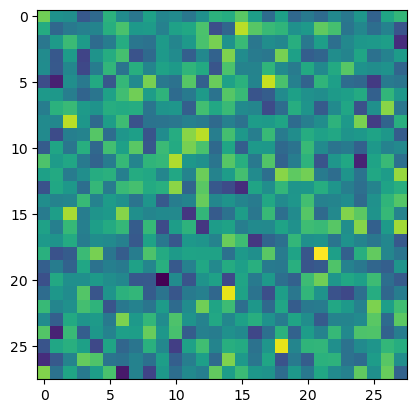

In [70]:
plt.imshow(samples.view(28,28))